In [9]:
import numpy as np
import pandas as pd
import pre_processing as pp

from matplotlib import pyplot as plt

from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from importlib import reload

<module 'pre_processing' from 'C:\\Users\\Pasha\\Documents\\GitHub\\ml-kaggle-MNIST\\src\\pre_processing.py'>

In [2]:
training = pp.get_training()
test = pp.get_test()

AttributeError: module 'pre_processing' has no attribute 'get_test_local'

In [11]:
X_train = np.array([x for x, y in training])
y_train = np.array([y for x, y in training])
X_test = test
X_train = X_train.reshape(X_train.shape[0], 1, 64, 64)
X_train = X_train.reshape(-1, 64, 64)
y_train = y_train.reshape(-1, 1)
X_train = X_train.reshape(len(X_train),-1)

In [12]:
X_test = X_test.reshape(X_test.shape[0], 1, 64, 64)
X_test = X_test.reshape(-1, 64, 64)
X_test = X_test.reshape(len(X_test),-1)

Text(0,0.5,'Cumulative explained variance')

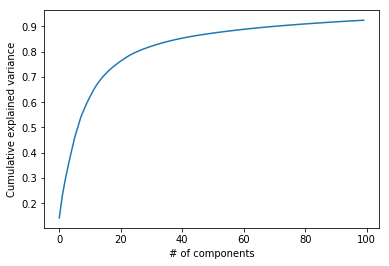

In [37]:
pca = PCA(100)
pca_full = pca.fit(X_train)

plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('# of components')
plt.ylabel('Cumulative explained variance')

In [15]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [16]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = cross_validation.train_test_split(X_train_pca,y_train,test_size=0.2,random_state=0)

In [17]:
#K_values = [1,5,10,25,100,500,1000,5000,10000]
K_values = [3,4,5,6,7,10,15,25,100]
metric = ["minkowski","hamming","manhattan","canberra","braycurtis","euclidean","chebyshev"]

params = {'n_neighbors':K_values, 'algorithm' : ['auto'], 'metric':metric}

clsf = KNeighborsClassifier()
grid_knn = GridSearchCV(estimator=clsf,param_grid=params,n_jobs=-1, verbose=2)
grid_knn.fit(X_train_cv, y_train_cv)

sorted(grid_knn.cv_results_.keys())

best_classifier = grid_knn.best_estimator_
best_classifier_submit = grid_knn.best_estimator_
best_params = grid_knn.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  32 out of  36 | elapsed: 19.2min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 19.5min finished
C:\Users\Pasha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [70]:
grid_knn.grid_scores_[0][0]['metric']
df = pd.DataFrame(columns=metric, index=K_values)
for i in grid_knn.grid_scores_:
    df[i[0]['metric']][i[0]['n_neighbors']] = i[1]

df

C:\Users\Pasha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\Pasha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,minkowski,hamming,manhattan,canberra,braycurtis,euclidean,chebyshev
5,0.909625,0.0998,0.907375,0.8883,0.914325,0.909625,0.894275
6,0.9085,0.0998,0.90715,0.88995,0.9142,0.9085,0.8941
7,0.9088,0.0998,0.906525,0.89165,0.9142,0.9088,0.894275
10,0.906075,0.101175,0.90375,0.8925,0.9126,0.906075,0.891375
15,0.901675,0.10115,0.898725,0.891425,0.9095,0.901675,0.888475
25,0.89555,0.10115,0.89345,0.8901,0.904175,0.89555,0.8805
100,0.868775,0.0998,0.86125,0.8754,0.883525,0.868775,0.851675


In [20]:
scores = grid_knn.cv_results_['mean_test_score'].reshape(12)
#plot_param_space_scores(scores, C_values)
best_clsf = best_classifier.fit(X_train_cv,y_train_cv)

C:\Users\Pasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
y_pred_knn = best_clsf.predict(X_test_cv)

In [22]:
acc_knn = accuracy_score(y_test_cv, y_pred_knn)
print("K-NearestNeighbors accuracy: ",acc_knn)

K-NearestNeighbors accuracy:  0.9225


In [24]:
best_clsf_submit = best_classifier_submit.fit(X_train_pca,y_train)

C:\Users\Pasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


In [25]:
knn_deep_pred = best_clsf_submit.predict(X_test_pca)

In [36]:
knn_deep_pred_nums = np.array([np.argmax(pred) for pred in knn_deep_pred])
knn_deep_pred_final = np.array([(i, x) for (i, x) in enumerate(knn_deep_pred)])
np.savetxt('../data/test_knn.csv', knn_deep_pred_final, delimiter=',', fmt='%d', header='Id,Label')